# Lyft Data Science Assignment
## Cancellation Fee policy

Rider Cancellations create bad experiences for both Drivers and Riders on the Lyft platform and impact Lyft financially. The Rider Cancels team is working to develop a new cancellation policy for Lyft, determining how and when riders should be charged a fee for cancelling their ride requests.

### Imports

In [1]:
import re
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.axes import Axes
from scipy.stats import chi2_contingency, chi2
from tqdm.notebook import tqdm

In [2]:
sns.set(style="whitegrid")
colors = sns.color_palette("deep")
figsize = (4, 3)
dpi = 150

### Utils

In [3]:
def show_values_on_bars(axs, h_v="v", value_format="{:.2f}", space=0.002):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + float(space)
                value = value_format.format(p.get_height())
                ax.text(_x, _y, value, ha="center")
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = value_format.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
        
def plot_cdf(
    data: np.ndarray, label: str, ax: Axes, color: str = colors[0], linewidth: float = 3
):
    sorted_data = np.sort(data)
    position = scipy.stats.rankdata(sorted_data, method="ordinal")
    cdf = position / data.shape[0]

    sorted_data = np.hstack((sorted_data, 1))
    cdf = np.hstack((cdf, 1))

    return ax.plot(
        sorted_data,
        cdf,
        color=color,
        linestyle="solid",
        label=label,
        linewidth=linewidth,
    )

### Load Data

#### Ride Data
1. `ride_id` - Unique identifier for the ride request.
2. `rider_id` - Unique identifier for the rider who requested the ride.
3. `driver_id` - Unique identifier for the driver.
4. `ride_type` - Type of ride requested (shared, normal).
5. `upfront_fare` - Final fare quote provided to the Rider before the request was made. This is surfaced to the rider after they enter both an origin and destination in the Lyft app.
6. `rider_paid_amount` - Total amount of money the rider paid to Lyft.
7. `eta_to_rider_pre_match` - ETA (estimated time to arrival) shown to the rider immediately before the ride request was made.Ride Data
8. `eta_to_rider_post_match` - ETA shown to the rider immediately after the ride request was matched to a specific driver driver.
9. `requested_at_local` - Time when ride was requested.
10. `accepted_at_local` - Time when the driver accepted the ride request.
11. `arrived_at_local` - Time when the driver arrived at the pickup location.
12. `picked_up_at_local` - Time when the rider was picked up from the pickup location.
13. `dropped_off_at_local` - Time when the rider was dropped off.
14. `actual_time_to_arrival` - Time (in seconds) for the driver to reach the designated pickup location after being matched with the ride request.
15. `cancellation_flag` - Boolean flag for whether the ride was cancelled.
16. `rider_request_number` - Sequential count of ride requests for each rider.

In [4]:
ride = pd.read_csv("ride_data.csv")

In [5]:
print(ride.shape)
ride.head()

(1402312, 16)


,ride_id,rider_id,driver_id,ride_type,upfront_fare,rider_paid_amount,eta_to_rider_pre_match,eta_to_rider_post_match,requested_at_local,accepted_at_local,arrived_at_local,picked_up_at_local,dropped_off_at_local,actual_time_to_arrival,cancellation_flag,rider_request_number
0,KCMXI4HAfLCjgHFR2qA1Lg==,AKTYnqStIa+/suWRUAQ60g==,c5U+DL4S+9Kd8xs0jW3ADg==,standard,12.13,17.40,60.0,21.0,2019-05-04 14:08:33.000 America/Los_Angeles,2019-05-04 14:08:43.775 America/Los_Angeles,2019-05-04 14:09:21.508 America/Los_Angeles,2019-05-04 14:10:02.000 America/Los_Angeles,2019-05-04 14:22:34.000 America/Los_Angeles,37.0,0,1
1,ERylrc+OvEb4gm84MxYmWQ==,ARxb2lRoxbrEgQgDEJIr7Q==,NaN,standard,77.76,1.00,60.0,NaN,2019-05-03 15:26:37.000 America/Los_Angeles,NaN,NaN,NaN,NaN,NaN,1,1
2,FKVvDcTRe0O1TDpg6uzLgQ==,ARxb2lRoxbrEgQgDEJIr7Q==,HBzAE1FuAnArUgou7Qetow==,standard,7.82,8.17,360.0,541.0,2019-05-10 19:26:29.000 America/Los_Angeles,2019-05-10 19:27:00.632 America/Los_Angeles,2019-05-10 19:37:22.502 America/Los_Angeles,2019-05-10 19:37:24.000 America/Los_Angeles,2019-05-10 19:44:22.000 America/Los_Angeles,621.0,0,2
3,ELtwBfng4uSyXpBseav1Bg==,AeWaFFe6cKFmfTEnEr6QBQ==,MX3XhXFZAjKpEDIRm5QoMg==,standard,14.76,14.82,60.0,126.0,2019-05-10 23:39:07.000 America/Los_Angeles,2019-05-10 23:39:32.725 America/Los_Angeles,2019-05-10 23:42:24.283 America/Los_Angeles,2019-05-10 23:42:28.000 America/Los_Angeles,2019-05-11 00:02:06.000 America/Los_Angeles,171.0,0,1
4,OmCaoDxSXwN3nJzg8Jwamw==,Au8G9PfP3KN3SUnTPO+mMQ==,lqj+gQA7gRITBlHwTCM8Rg==,standard,18.05,17.78,360.0,587.0,2019-05-08 13:52:08.000 America/Los_Angeles,2019-05-08 13:53:24.871 America/Los_Angeles,2019-05-08 14:03:34.987 America/Los_Angeles,2019-05-08 14:03:39.000 America/Los_Angeles,2019-05-08 14:18:35.000 America/Los_Angeles,610.0,0,1


In [6]:
def parse_date(date_string):
    if isinstance(date_string, str):
        return " ".join(date_string.split(" ")[:2])
    else:
        return date_string

In [7]:
date_cols = [
    "requested_at_local",
    "accepted_at_local",
    "arrived_at_local",
    "picked_up_at_local",
    "dropped_off_at_local",
]

for col in tqdm(date_cols):
    ride.loc[:, col] = ride[col].apply(parse_date)
    ride.loc[:, col] = pd.to_datetime(ride[col])

In [8]:
ride.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1402312 entries, 0 to 1402311
Data columns (total 16 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   ride_id                  1402312 non-null  object        
 1   rider_id                 1402312 non-null  object        
 2   driver_id                1367819 non-null  object        
 3   ride_type                1402312 non-null  object        
 4   upfront_fare             1397335 non-null  float64       
 5   rider_paid_amount        1402312 non-null  float64       
 6   eta_to_rider_pre_match   1334909 non-null  float64       
 7   eta_to_rider_post_match  1367790 non-null  float64       
 8   requested_at_local       1402312 non-null  datetime64[ns]
 9   accepted_at_local        1367790 non-null  datetime64[ns]
 10  arrived_at_local         1193519 non-null  datetime64[ns]
 11  picked_up_at_local       1193511 non-null  datetime64[ns]
 12  

In [9]:
ride.isnull().sum()

ride_id                         0
rider_id                        0
driver_id                   34493
ride_type                       0
upfront_fare                 4977
rider_paid_amount               0
eta_to_rider_pre_match      67403
eta_to_rider_post_match     34522
requested_at_local              0
accepted_at_local           34522
arrived_at_local           208793
picked_up_at_local         208801
dropped_off_at_local       208825
actual_time_to_arrival     208821
cancellation_flag               0
rider_request_number            0
dtype: int64

In [10]:
ride.nunique()

ride_id                    1402312
rider_id                    530756
driver_id                    36385
ride_type                        2
upfront_fare                 12640
rider_paid_amount            13490
eta_to_rider_pre_match        1243
eta_to_rider_post_match       1528
requested_at_local         1110039
accepted_at_local          1367297
arrived_at_local           1193260
picked_up_at_local          975231
dropped_off_at_local        974956
actual_time_to_arrival        1910
cancellation_flag                2
rider_request_number           107
dtype: int64

In [11]:
ride.head()

,ride_id,rider_id,driver_id,ride_type,upfront_fare,rider_paid_amount,eta_to_rider_pre_match,eta_to_rider_post_match,requested_at_local,accepted_at_local,arrived_at_local,picked_up_at_local,dropped_off_at_local,actual_time_to_arrival,cancellation_flag,rider_request_number
0,KCMXI4HAfLCjgHFR2qA1Lg==,AKTYnqStIa+/suWRUAQ60g==,c5U+DL4S+9Kd8xs0jW3ADg==,standard,12.13,17.40,60.0,21.0,2019-05-04 14:08:33,2019-05-04 14:08:43.775,2019-05-04 14:09:21.508,2019-05-04 14:10:02,2019-05-04 14:22:34,37.0,0,1
1,ERylrc+OvEb4gm84MxYmWQ==,ARxb2lRoxbrEgQgDEJIr7Q==,NaN,standard,77.76,1.00,60.0,NaN,2019-05-03 15:26:37,NaT,NaT,NaT,NaT,NaN,1,1
2,FKVvDcTRe0O1TDpg6uzLgQ==,ARxb2lRoxbrEgQgDEJIr7Q==,HBzAE1FuAnArUgou7Qetow==,standard,7.82,8.17,360.0,541.0,2019-05-10 19:26:29,2019-05-10 19:27:00.632,2019-05-10 19:37:22.502,2019-05-10 19:37:24,2019-05-10 19:44:22,621.0,0,2
3,ELtwBfng4uSyXpBseav1Bg==,AeWaFFe6cKFmfTEnEr6QBQ==,MX3XhXFZAjKpEDIRm5QoMg==,standard,14.76,14.82,60.0,126.0,2019-05-10 23:39:07,2019-05-10 23:39:32.725,2019-05-10 23:42:24.283,2019-05-10 23:42:28,2019-05-11 00:02:06,171.0,0,1
4,OmCaoDxSXwN3nJzg8Jwamw==,Au8G9PfP3KN3SUnTPO+mMQ==,lqj+gQA7gRITBlHwTCM8Rg==,standard,18.05,17.78,360.0,587.0,2019-05-08 13:52:08,2019-05-08 13:53:24.871,2019-05-08 14:03:34.987,2019-05-08 14:03:39,2019-05-08 14:18:35,610.0,0,1


#### Experiment Data
Lyft recently launched a randomized experiment to test the effect charging riders cancellation fees, of varying amounts, if they cancel a ride request. Riders were assigned to each variant and informed that the new cancel fee would apply to all future rides. This experiment was in effect for the entire duration of Ride Request Dataset.
1. `rider_id` - unique identifier for a Rider.
2. `variant` - experiment group the Rider was in.
3. `cancel_penalty` - cancellation penalty fee for the variant.

In [12]:
exp = pd.read_csv("experiment_data.csv")

In [13]:
print(exp.shape)
exp.head()

(530756, 3)


,rider_id,variant,cancel_penalty
0,+++3990cLNPGgaPm+ripGg==,control,5.0
1,+++stf7DqWcT8LMTYbXrwA==,control,5.0
2,++07zTPYFhvA5Ug72kRd0w==,treatment1,3.0
3,++08hetKFBNoOO5XHAH/5A==,treatment2,1.0
4,++0YwCvnfyMWSNH3wpyP1g==,treatment2,1.0


In [14]:
exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530756 entries, 0 to 530755
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   rider_id        530756 non-null  object 
 1   variant         530756 non-null  object 
 2   cancel_penalty  530756 non-null  float64
dtypes: float64(1), object(2)
memory usage: 12.1+ MB


#### Concatenate the data

In [15]:
df = ride.merge(exp, how="outer", on="rider_id")
print(df.shape)
df.head()

(1402312, 18)


,ride_id,rider_id,driver_id,ride_type,upfront_fare,rider_paid_amount,eta_to_rider_pre_match,eta_to_rider_post_match,requested_at_local,accepted_at_local,arrived_at_local,picked_up_at_local,dropped_off_at_local,actual_time_to_arrival,cancellation_flag,rider_request_number,variant,cancel_penalty
0,KCMXI4HAfLCjgHFR2qA1Lg==,AKTYnqStIa+/suWRUAQ60g==,c5U+DL4S+9Kd8xs0jW3ADg==,standard,12.13,17.40,60.0,21.0,2019-05-04 14:08:33,2019-05-04 14:08:43.775,2019-05-04 14:09:21.508,2019-05-04 14:10:02,2019-05-04 14:22:34,37.0,0,1,treatment1,3.0
1,ERylrc+OvEb4gm84MxYmWQ==,ARxb2lRoxbrEgQgDEJIr7Q==,NaN,standard,77.76,1.00,60.0,NaN,2019-05-03 15:26:37,NaT,NaT,NaT,NaT,NaN,1,1,treatment2,1.0
2,FKVvDcTRe0O1TDpg6uzLgQ==,ARxb2lRoxbrEgQgDEJIr7Q==,HBzAE1FuAnArUgou7Qetow==,standard,7.82,8.17,360.0,541.0,2019-05-10 19:26:29,2019-05-10 19:27:00.632,2019-05-10 19:37:22.502,2019-05-10 19:37:24,2019-05-10 19:44:22,621.0,0,2,treatment2,1.0
3,ELtwBfng4uSyXpBseav1Bg==,AeWaFFe6cKFmfTEnEr6QBQ==,MX3XhXFZAjKpEDIRm5QoMg==,standard,14.76,14.82,60.0,126.0,2019-05-10 23:39:07,2019-05-10 23:39:32.725,2019-05-10 23:42:24.283,2019-05-10 23:42:28,2019-05-11 00:02:06,171.0,0,1,treatment2,1.0
4,OmCaoDxSXwN3nJzg8Jwamw==,Au8G9PfP3KN3SUnTPO+mMQ==,lqj+gQA7gRITBlHwTCM8Rg==,standard,18.05,17.78,360.0,587.0,2019-05-08 13:52:08,2019-05-08 13:53:24.871,2019-05-08 14:03:34.987,2019-05-08 14:03:39,2019-05-08 14:18:35,610.0,0,1,treatment2,1.0


### EDA

In [16]:
print(
    f"Minimum date: {min(ride['requested_at_local'])} \nMaximum date: {max(ride['requested_at_local'])}"
)

Minimum date: 2019-04-14 17:00:01 
Maximum date: 2019-05-26 16:59:56


The experiment took place for 43 days from April, 14 to May, 26.

In [17]:
experiment = exp.groupby("variant")["cancel_penalty"].agg(["mean", "count"]).T
experiment.rename({"mean": "Cancellation fee", "count": "Number of riders"}, inplace=True)
experiment.append(
    experiment.agg(lambda x: x[1] * 100 / experiment.iloc[1, :].sum()).rename(
        "%"
    )
).round(2)

variant,control,treatment1,treatment2
Cancellation fee,5.00,3.00,1.00
Number of riders,176856.00,176900.00,177000.00
%,33.32,33.33,33.35


The riders have been randomly assigned to 3 experiment groups.

Cancellation penalty fee for the variant:
* Control: \$5
* Treatment 1: \$3
* Treatment 2: \$1

In [18]:
df["ride_type"].value_counts(normalize=True).round(3)

standard    0.658
shared      0.342
Name: ride_type, dtype: float64

In [19]:
df.groupby("variant")["ride_type"].value_counts(normalize=True).round(3).unstack()

ride_type,shared,standard
variant,,
control,0.339,0.661
treatment1,0.344,0.656
treatment2,0.342,0.658


In [20]:
df.groupby("variant")["cancellation_flag"].value_counts(normalize=True).round(3).unstack()

cancellation_flag,0,1
variant,,
control,0.900,0.100
treatment1,0.846,0.154
treatment2,0.812,0.188


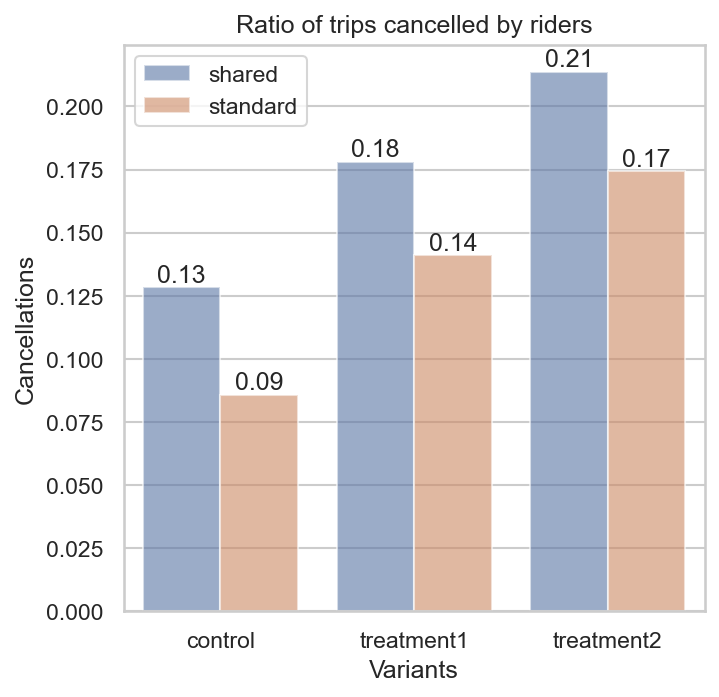

In [21]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=dpi)

g = sns.barplot(
    x="variant",
    y="cancellation_flag",
    hue="ride_type",
    data=df.groupby(["variant", "ride_type"])["cancellation_flag"].mean().reset_index(),
    alpha=0.6,
    ax=ax
)
show_values_on_bars(g)
plt.legend(loc="upper left")
plt.title("Ratio of trips cancelled by riders")
plt.ylabel("Cancellations")
plt.xlabel("Variants")
plt.show()

In [22]:
df.groupby(["variant","ride_type", ])[["ride_type"]].count().unstack()

ride_type         
ride_type     shared standard
variant                      
control       156346   304630
treatment1    161815   308634
treatment2    161037   309850

In [23]:
for v in ["control", "treatment1", "treatment2"]:
    n_rides = df.query(f"variant=='{v}' & cancellation_flag==0")["ride_id"].nunique()
    n_users = df.query(f"variant=='{v}'")["rider_id"].nunique()
    rides_per_rider = (n_rides / n_users)
    print(f"Rides per rider in {v} group: {rides_per_rider:.3f}")
    print(f"Number of completed rides: {n_rides}")
    print()

Rides per rider in control group: 2.345
Number of completed rides: 414762

Rides per rider in treatment1 group: 2.251
Number of completed rides: 398114

Rides per rider in treatment2 group: 2.160
Number of completed rides: 382386



In [24]:
df.groupby(["variant"])["rider_paid_amount"].agg(["sum", "mean"])

,sum,mean
variant,,
control,6493070.60,14.085485
treatment1,6198026.56,13.174705
treatment2,5829468.61,12.379761


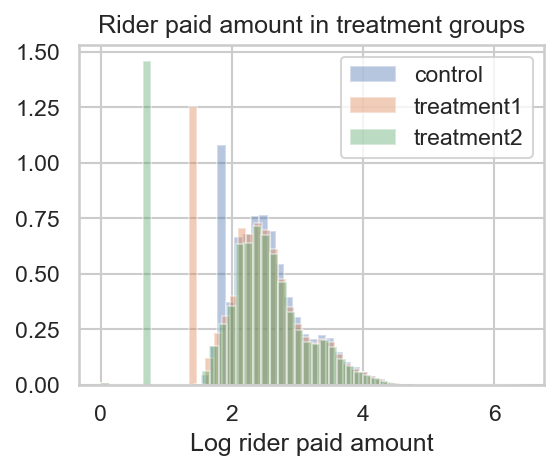

In [25]:
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

for v in ["control", "treatment1", "treatment2"]:
    sns.distplot(
        np.log1p(df.loc[(df["variant"] == v), "rider_paid_amount"]),
        kde=False,
        label=v,
        norm_hist=True,
    )

plt.legend()
plt.xlabel("Log rider paid amount")
plt.title("Rider paid amount in treatment groups")
plt.show()

In [26]:
(
    (df.groupby(["variant", "cancellation_flag"])[["rider_paid_amount"]].agg("sum"))
    .unstack()
    .T
    / df.groupby("variant")["rider_paid_amount"].sum()
    * 100
).round(3).reset_index(0, drop=True)

variant,control,treatment1,treatment2
cancellation_flag,,,
0,96.441,96.499,98.482
1,3.559,3.501,1.518


In [27]:
df.groupby("variant")["rider_paid_amount"].sum()

variant
control       6493070.60
treatment1    6198026.56
treatment2    5829468.61
Name: rider_paid_amount, dtype: float64

In [28]:
rider_fees = (
    df.query("cancellation_flag == 1")
    .groupby(["ride_type", "variant"])["rider_paid_amount"]
    .agg(["sum"])
    .unstack()
)

rider_fees.append(rider_fees.sum().rename("Total")).round(2)

sum                      
variant     control treatment1 treatment2
ride_type                                
shared     100430.0    86499.0    34436.0
standard   130640.0   130506.0    54065.0
Total      231070.0   217005.0    88501.0

In [29]:
rider_payments = (
    df.query("cancellation_flag == 0")
    .groupby(["ride_type", "variant"])["rider_paid_amount"]
    .agg(["sum", "mean"])
    .unstack()
)

rider_payments.append(
    rider_payments.agg(
        {
            ("sum", "control"): "sum",
            ("sum", "treatment1"): "sum",
            ("sum", "treatment2"): "sum",
            ("mean", "control"): "mean",
            ("mean", "treatment1"): "mean",
            ("mean", "treatment2"): "mean",
        }
    ).rename("Total")
).round(3)

sum                            mean                      
variant       control  treatment1  treatment2 control treatment1 treatment2
ride_type                                                                  
shared     1319925.85  1283343.19  1225873.98   9.687      9.651      9.683
standard   4942074.75  4697678.37  4515093.63  17.745     17.718     17.652
Total      6262000.60  5981021.56  5740967.61  13.716     13.684     13.667

In [30]:
paid_amt_c = df.loc[
    (df["variant"] == "control") & (df["cancellation_flag"] == 0),
    "rider_paid_amount",
].values

paid_amt_t1 = df.loc[
    (df["variant"] == "treatment1") & (df["cancellation_flag"] == 0),
    "rider_paid_amount",
].values

paid_amt_t2 = df.loc[
    (df["variant"] == "treatment2") & (df["cancellation_flag"] == 0),
    "rider_paid_amount",
].values

Difference between mean rider paid amount across variants:

In [31]:
control_t1 = np.mean(paid_amt_t1) - np.mean(paid_amt_c)
control_t2 = np.mean(paid_amt_t2) - np.mean(paid_amt_c)
t1_t2 = np.mean(paid_amt_t2) - np.mean(paid_amt_t1)
print(
    f"Difference between Control and Treatment_1: {control_t1:.4f}",
)

print(
    f"Difference between Control and Treatment_2: {control_t2:.4f}",
)

print(
    f"Difference between Treatment_1 and Treatment_2: {t1_t2:.4f}",
)

Difference between Control and Treatment_1: -0.0744
Difference between Control and Treatment_2: -0.0843
Difference between Treatment_1 and Treatment_2: -0.0098


In [32]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    return boundaries


def get_bootstrap_mean(sample, n_samples=1000):
    mean_scores_list = list(
        map(
            np.mean,
            get_bootstrap_samples(
                sample,
                n_samples=n_samples,
            ),
        )
    )
    return mean_scores_list

In [33]:
%%time
np.random.seed(0)

control_mean_scores = get_bootstrap_mean(paid_amt_c)
treatment1_mean_scores = get_bootstrap_mean(paid_amt_t1)
treatment2_mean_scores = get_bootstrap_mean(paid_amt_t2)

CPU times: user 33.1 s, sys: 17.8 s, total: 50.9 s
Wall time: 53.5 s


In [34]:
print("95% confidence interval for the mean paid amount")
print(
    "Control:",
    np.round(stat_intervals(control_mean_scores, 0.05), 3),
)
print(
    "Treatment_1:",
    np.round(stat_intervals(treatment1_mean_scores, 0.05), 3),
)
print(
    "Treatment_2:",
    np.round(stat_intervals(treatment2_mean_scores, 0.05), 3),
)

95% confidence interval for the mean paid amount
Control: [15.063 15.134]
Treatment_1: [14.986 15.061]
Treatment_2: [14.975 15.054]


In [35]:
delta_mean_scores_c_t1 = list(
    map(lambda x: x[1] - x[0], zip(control_mean_scores, treatment1_mean_scores))
)
delta_mean_scores_c_t2 = list(
    map(lambda x: x[1] - x[0], zip(control_mean_scores, treatment2_mean_scores))
)
delta_mean_scores_t1_t2 = list(
    map(lambda x: x[1] - x[0], zip(treatment1_mean_scores, treatment2_mean_scores))
)

In [36]:
print("95% confidence interval for the difference between means:")
print(
    "Control and Treatment_1",
    np.round(stat_intervals(delta_mean_scores_c_t1, 0.05), 3),
)
print(
    "Control and Treatment_2",
    np.round(stat_intervals(delta_mean_scores_c_t2, 0.05), 3),
)
print(
    "Treatment_1 and Treatment_2",
    np.round(stat_intervals(delta_mean_scores_t1_t2, 0.05), 3),
)

95% confidence interval for the difference between means:
Control and Treatment_1 [-0.127 -0.025]
Control and Treatment_2 [-0.135 -0.033]
Treatment_1 and Treatment_2 [-0.06   0.046]


Let's check the difference across ride types

In [37]:
shared_paid_amt_c = df.loc[
    (df["variant"] == "control")
    & (df["cancellation_flag"] == 0)
    & (df["ride_type"] == "shared"),
    "rider_paid_amount",
].values

shared_paid_amt_t1 = df.loc[
    (df["variant"] == "treatment1")
    & (df["cancellation_flag"] == 0)
    & (df["ride_type"] == "shared"),
    "rider_paid_amount",
].values

shared_paid_amt_t2 = df.loc[
    (df["variant"] == "treatment2")
    & (df["cancellation_flag"] == 0)
    & (df["ride_type"] == "shared"),
    "rider_paid_amount",
].values


standard_paid_amt_c = df.loc[
    (df["variant"] == "control")
    & (df["cancellation_flag"] == 0)
    & (df["ride_type"] == "standard"),
    "rider_paid_amount",
].values

standard_paid_amt_t1 = df.loc[
    (df["variant"] == "treatment1")
    & (df["cancellation_flag"] == 0)
    & (df["ride_type"] == "standard"),
    "rider_paid_amount",
].values

standard_paid_amt_t2 = df.loc[
    (df["variant"] == "treatment2")
    & (df["cancellation_flag"] == 0)
    & (df["ride_type"] == "standard"),
    "rider_paid_amount",
].values

In [38]:
control_t1 = np.mean(shared_paid_amt_t1) - np.mean(shared_paid_amt_c)
control_t2 = np.mean(shared_paid_amt_t2) - np.mean(shared_paid_amt_c)
t1_t2 = np.mean(shared_paid_amt_t2) - np.mean(shared_paid_amt_t1)

print("Difference in mean paid amount in Shared rides:")
print(
    f"Control and Treatment_1: {control_t1:.4f}",
)

print(
    f"Control and Treatment_2: {control_t2:.4f}",
)

print(
    f"Treatment_1 and Treatment_2: {t1_t2:.4f}",
)

print()
control_t1 = np.mean(standard_paid_amt_t1) - np.mean(standard_paid_amt_c)
control_t2 = np.mean(standard_paid_amt_t2) - np.mean(standard_paid_amt_c)
t1_t2 = np.mean(standard_paid_amt_t2) - np.mean(standard_paid_amt_t1)

print("Difference in mean paid amount in Standard rides:")
print(
    f"Control and Treatment_1: {control_t1:.4f}",
)

print(
    f"Control and Treatment_2: {control_t2:.4f}",
)

print(
    f"Treatment_1 and Treatment_2: {t1_t2:.4f}",
)

Difference in mean paid amount in Shared rides:
Control and Treatment_1: -0.0363
Control and Treatment_2: -0.0038
Treatment_1 and Treatment_2: 0.0325

Difference in mean paid amount in Standard rides:
Control and Treatment_1: -0.0269
Control and Treatment_2: -0.0933
Treatment_1 and Treatment_2: -0.0664


In [39]:
%%time
np.random.seed(0)

standard_control_mean_scores = get_bootstrap_mean(standard_paid_amt_c)
standard_treatment1_mean_scores = get_bootstrap_mean(standard_paid_amt_t1)
standard_treatment2_mean_scores = get_bootstrap_mean(standard_paid_amt_t2)

shared_control_mean_scores = get_bootstrap_mean(shared_paid_amt_c)
shared_treatment1_mean_scores = get_bootstrap_mean(shared_paid_amt_t1)
shared_treatment2_mean_scores = get_bootstrap_mean(shared_paid_amt_t2)

CPU times: user 40.1 s, sys: 9.45 s, total: 49.6 s
Wall time: 49.9 s


In [40]:
print("95% confidence interval for the Shared rides mean paid amount:")

print(
    "Control:",
    np.round(stat_intervals(shared_control_mean_scores, 0.05), 3),
)
print(
    "Treatment_1:",
    np.round(stat_intervals(shared_treatment1_mean_scores, 0.05), 3),
)
print(
    "Treatment_2:",
    np.round(stat_intervals(shared_treatment2_mean_scores, 0.05), 3),
)

print()

print("95% confidence interval for the Standard rides mean paid amount:")

print(
    "Control:",
    np.round(stat_intervals(standard_control_mean_scores, 0.05), 3),
)
print(
    "Treatment_1:",
    np.round(stat_intervals(standard_treatment1_mean_scores, 0.05), 3),
)
print(
    "Treatment_2:",
    np.round(stat_intervals(standard_treatment2_mean_scores, 0.05), 3),
)

95% confidence interval for the Shared rides mean paid amount:
Control: [9.653 9.722]
Treatment_1: [9.614 9.684]
Treatment_2: [9.645 9.723]

95% confidence interval for the Standard rides mean paid amount:
Control: [17.698 17.794]
Treatment_1: [17.671 17.768]
Treatment_2: [17.602 17.706]


In [41]:
delta_mean_scores_c_t1 = list(
    map(
        lambda x: x[1] - x[0],
        zip(shared_control_mean_scores, shared_treatment1_mean_scores),
    )
)
delta_mean_scores_c_t2 = list(
    map(
        lambda x: x[1] - x[0],
        zip(shared_control_mean_scores, shared_treatment2_mean_scores),
    )
)
delta_mean_scores_t1_t2 = list(
    map(
        lambda x: x[1] - x[0],
        zip(shared_treatment1_mean_scores, shared_treatment2_mean_scores),
    )
)

print("95% confidence interval for the difference in mean paid amount in Shared rides:")
print(
    "Control and Treatment_1",
    np.round(stat_intervals(delta_mean_scores_c_t1, 0.05), 3),
)
print(
    "Control and Treatment_2",
    np.round(stat_intervals(delta_mean_scores_c_t2, 0.05), 3),
)
print(
    "Treatment_1 and Treatment_2",
    np.round(stat_intervals(delta_mean_scores_t1_t2, 0.05), 3),
)

print()
delta_mean_scores_c_t1 = list(
    map(
        lambda x: x[1] - x[0],
        zip(standard_control_mean_scores, standard_treatment1_mean_scores),
    )
)
delta_mean_scores_c_t2 = list(
    map(
        lambda x: x[1] - x[0],
        zip(standard_control_mean_scores, standard_treatment2_mean_scores),
    )
)
delta_mean_scores_t1_t2 = list(
    map(
        lambda x: x[1] - x[0],
        zip(standard_treatment1_mean_scores, standard_treatment2_mean_scores),
    )
)

print(
    "95% confidence interval for the difference in mean paid amount in Standard rides:"
)
print(
    "Control and Treatment_1",
    np.round(stat_intervals(delta_mean_scores_c_t1, 0.05), 3),
)
print(
    "Control and Treatment_2",
    np.round(stat_intervals(delta_mean_scores_c_t2, 0.05), 3),
)
print(
    "Treatment_1 and Treatment_2",
    np.round(stat_intervals(delta_mean_scores_t1_t2, 0.05), 3),
)

95% confidence interval for the difference in mean paid amount in Shared rides:
Control and Treatment_1 [-0.089  0.01 ]
Control and Treatment_2 [-0.055  0.047]
Treatment_1 and Treatment_2 [-0.018  0.085]

95% confidence interval for the difference in mean paid amount in Standard rides:
Control and Treatment_1 [-0.092  0.043]
Control and Treatment_2 [-0.165 -0.024]
Treatment_1 and Treatment_2 [-0.13   0.005]


### Hypothesis Testing
To run a statistical test, we start by formulating null and alternative hypotheses in terms of random variables. <br>
The null hypothesis is that the ratio of trips cancelled by riders in the control and treatment groups are the same.

$H_0 : M_{control} = M_{treatment}$<br>
$H_1 : M_{control} \neq M_{treatment}$

Each rider in the dataset has requested some number of rides and has cancelled some (or none) of them. So each rider is characterized by the number of rides and the number of cancellations.

In [42]:
test_data = (
    df.groupby(["ride_type", "variant", "rider_id"])[["ride_id", "cancellation_flag"]]
    .agg({"ride_id": "count", "cancellation_flag": "sum"})
    .reset_index()
)

test_data.rename(columns={"ride_id": "rides", "cancellation_flag": "cancellations"}, inplace=True)

test_data.head()

,ride_type,variant,rider_id,rides,cancellations
0,shared,control,++0bPPtI4KaXB8Cu7ByDMg==,9,0
1,shared,control,++1hNPNAMjJz6NwsrH8UCQ==,1,0
2,shared,control,++23cjRT/n4usa6HOUPKPQ==,4,0
3,shared,control,++3QfvuDev8xK29lPiT1JA==,1,0
4,shared,control,++8/eiSOAscsR5i1XU/nqA==,1,0


The distribution of rides across riders resembles log-normal: most of the riders had a small number of rides, and few riders - a lot. 

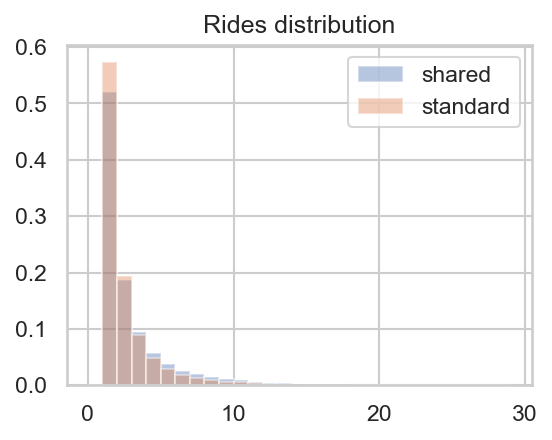

In [43]:
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

rides_shared = test_data["rides"][test_data["ride_type"]=="shared"].values
cancellations_shared = test_data["cancellations"][test_data["ride_type"]=="shared"].values

rides_standard = test_data["rides"][test_data["ride_type"]=="standard"].values
cancellations_standard = test_data["cancellations"][test_data["ride_type"]=="standard"].values

sns.distplot(rides_shared, bins=range(0, 30), ax=ax, kde=False, norm_hist=True, label="shared")
sns.distplot(rides_standard, bins=range(0, 30), ax=ax, kde=False, norm_hist=True, label="standard")
ax.set_title("Rides distribution")
plt.legend()
plt.show()

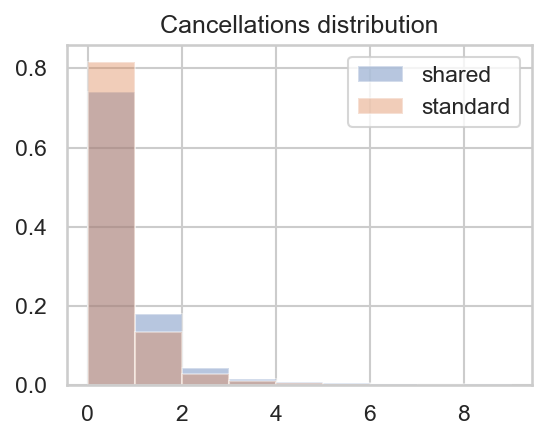

In [44]:
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
sns.distplot(
    cancellations_shared,
    bins=range(0, 10),
    ax=ax,
    kde=False,
    norm_hist=True,
    label="shared",
)
sns.distplot(
    cancellations_standard,
    bins=range(0, 10),
    ax=ax,
    kde=False,
    norm_hist=True,
    label="standard",
)
ax.set_title("Cancellations distribution")
plt.legend()
plt.show()

Cancellation ratio (CR) in the control and treatment groups will differ by some uplift:

$GlobalCR = \frac{\Sigma_{r \in Riders} cancellations_{r}}{\Sigma_{r \in Riders} rides_{r}}$

$Rate_{treatment} = Rate_{control}(1 + uplift)$

In [45]:
def delta_method_cancels(
    cancels_0, rides_0, cancels_1, rides_1, alpha=0.05, verbose=False
):
    """
    Calculates two-sided p-values for all the experiments on CTRs using delta-method
    :param cancels_0: np.array shape (n_experiments, n_users), clicks of every user from control group in every experiment
    :param rides_0: np.array shape (n_experiments, n_users), views of every user from control group in every experiment
    :param cancels_1: np.array shape (n_experiments, n_users), clicks of every user from treatment group in every experiment
    :param rides_1: np.array shape (n_experiments, n_users), views of every user from treatment group in every experiment
    :return: np.array shape (n_experiments), two-sided p-values of delta-method on CTRs in all the experimetns
    """
    n_experiments, n_users_0 = rides_0.shape
    n_experiments, n_users_1 = rides_1.shape

    mean_cancels_0, var_cancels_0 = np.mean(cancels_0, axis=1), np.var(
        cancels_0, axis=1
    )
    mean_cancels_1, var_cancels_1 = np.mean(cancels_1, axis=1), np.var(
        cancels_1, axis=1
    )

    mean_rides_0, var_rides_0 = np.mean(rides_0, axis=1), np.var(rides_0, axis=1)
    mean_rides_1, var_rides_1 = np.mean(rides_1, axis=1), np.var(rides_1, axis=1)

    cov_0 = np.mean(
        (cancels_0 - mean_cancels_0.reshape(-1, 1))
        * (rides_0 - mean_rides_0.reshape(-1, 1)),
        axis=1,
    )
    cov_1 = np.mean(
        (cancels_1 - mean_cancels_1.reshape(-1, 1))
        * (rides_1 - mean_rides_1.reshape(-1, 1)),
        axis=1,
    )

    var_0 = (
        var_cancels_0 / mean_rides_0 ** 2
        + var_rides_0 * mean_cancels_0 ** 2 / mean_rides_0 ** 4
        - 2 * mean_cancels_0 / mean_rides_0 ** 3 * cov_0
    )
    var_1 = (
        var_cancels_1 / mean_rides_1 ** 2
        + var_rides_1 * mean_cancels_1 ** 2 / mean_rides_1 ** 4
        - 2 * mean_cancels_1 / mean_rides_1 ** 3 * cov_1
    )

    ctrs_0 = np.sum(cancels_0, axis=1) / np.sum(rides_0, axis=1)
    ctrs_1 = np.sum(cancels_1, axis=1) / np.sum(rides_1, axis=1)

    z = scipy.stats.norm.ppf(1 - alpha / 2.0)
    upper = (ctrs_1 - ctrs_0) + z * np.sqrt(var_0 / n_users_0 + var_1 / n_users_1)
    lower = (ctrs_1 - ctrs_0) - z * np.sqrt(var_0 / n_users_0 + var_1 / n_users_1)

    if verbose:
        print(
            f"Ratio of cancellations: Control {ctrs_0[0]:.4f}, Treatment {ctrs_1[0]:.4f}"
        )

    z_stats = (ctrs_1 - ctrs_0) / np.sqrt(var_0 / n_users_0 + var_1 / n_users_1)
    p_ctr_delta = 2 * np.minimum(
        scipy.stats.norm(0, 1).cdf(z_stats), 1 - scipy.stats.norm(0, 1).cdf(z_stats)
    )
    mean = ctrs_1 - ctrs_0
    return p_ctr_delta, lower, mean, upper

In [182]:
def calc_delta_method(
    variant_0,
    variant_1,
    ride_type_0=None,
    ride_type_1=None,
    test_type=None,
    verbose=False,
):
    if test_type == "total":
        p, lower, mean, upper = delta_method_cancels(
            test_data[(test_data["variant"] == variant_0)][
                "cancellations"
            ].values.reshape(1, -1),
            test_data[(test_data["variant"] == variant_0)]["rides"].values.reshape(
                1, -1
            ),
            test_data[(test_data["variant"] == variant_1)][
                "cancellations"
            ].values.reshape(1, -1),
            test_data[(test_data["variant"] == variant_1)]["rides"].values.reshape(
                1, -1
            ),
            verbose=verbose,
        )
    else:
        p, lower, mean, upper = delta_method_cancels(
            test_data[
                (test_data["variant"] == variant_0)
                & (test_data["ride_type"] == ride_type_0)
            ]["cancellations"].values.reshape(1, -1),
            test_data[
                (test_data["variant"] == variant_0)
                & (test_data["ride_type"] == ride_type_0)
            ]["rides"].values.reshape(1, -1),
            test_data[
                (test_data["variant"] == variant_1)
                & (test_data["ride_type"] == ride_type_1)
            ]["cancellations"].values.reshape(1, -1),
            test_data[
                (test_data["variant"] == variant_1)
                & (test_data["ride_type"] == ride_type_1)
            ]["rides"].values.reshape(1, -1),
            verbose=verbose,
        )
    return p, lower, mean, upper


def get_delta_method_results(
    variant_0="control", variant_1="treatment1", verbose=False
):
    print(f"Change in ratio of cancelled trips between {variant_0} and {variant_1}:")
    print("-" * 90)

    p, lower, mean, upper = calc_delta_method(
        variant_0, variant_1, None, None, test_type="total", verbose=verbose
    )
    print(
        f"Total rides: p-value {p[0]:.4f}, delta {mean[0]:.4f}, 95% CI [{lower[0]:.4f}, {upper[0]:.4f}]"
    )
    print()
    p, lower, mean, upper = calc_delta_method(
        variant_0,
        variant_1,
        ride_type_0="shared",
        ride_type_1="shared",
        verbose=verbose,
    )
    print(
        f"Shared rides: p-value {p[0]:.4f}, delta {mean[0]:.4f}, 95% CI [{lower[0]:.4f}, {upper[0]:.4f}]"
    )

    print()
    p, lower, mean, upper = calc_delta_method(
        variant_0,
        variant_1,
        ride_type_0="standard",
        ride_type_1="standard",
        verbose=verbose,
    )
    print(
        f"Standard rides: p-value {p[0]:.4f}, delta {mean[0]:.4f}, 95% CI [{lower[0]:.4f}, {upper[0]:.4f}]"
    )
    print()

In [183]:
calc_delta_method("control", "control", "standard", "shared", verbose=True)

Ratio of cancellations: Control 0.0858, Treatment 0.1285


(array([0.]), array([0.04011047]), array([0.04270184]), array([0.04529322]))

In [184]:
get_delta_method_results(variant_0="control", variant_1="treatment1", verbose=True)
get_delta_method_results(variant_0="control", variant_1="treatment2", verbose=True)

Change in ratio of cancelled trips between control and treatment1:
------------------------------------------------------------------------------------------
Ratio of cancellations: Control 0.1003, Treatment 0.1538
Total rides: p-value 0.0000, delta 0.0535, 95% CI [0.0514, 0.0556]

Ratio of cancellations: Control 0.1285, Treatment 0.1782
Shared rides: p-value 0.0000, delta 0.0497, 95% CI [0.0459, 0.0536]

Ratio of cancellations: Control 0.0858, Treatment 0.1410
Standard rides: p-value 0.0000, delta 0.0552, 95% CI [0.0527, 0.0577]

Change in ratio of cancelled trips between control and treatment2:
------------------------------------------------------------------------------------------
Ratio of cancellations: Control 0.1003, Treatment 0.1879
Total rides: p-value 0.0000, delta 0.0877, 95% CI [0.0853, 0.0901]

Ratio of cancellations: Control 0.1285, Treatment 0.2138
Shared rides: p-value 0.0000, delta 0.0854, 95% CI [0.0810, 0.0897]

Ratio of cancellations: Control 0.0858, Treatment 0.17

#### Sanity check with A/A test
I will sample treatment and control groups from exactly the same distribution, so H0 will be true here. The p-value correctly controls FPR if and only if the p-value is distributed uniformly on [0, 1] for A/A tests.
For A/A tests, p-value falls below the 0.05 threshold in only 5% of cases. This is exactly the uniformness requirement.

In [49]:
cancels_data = test_data[
    (test_data["variant"] == "control") & (test_data["ride_type"] == "standard")
]["cancellations"].values
rides_data = test_data[
    (test_data["variant"] == "control") & (test_data["ride_type"] == "standard")
]["rides"].values

In [50]:
np.random.seed(0)
indices = np.random.randint(
    0,
    len(cancels_data),
    (1000, len(cancels_data)),
)
rides_aa_0 = rides_data[indices]
cancels_aa_0 = cancels_data[indices]

np.random.seed(1)
indices = np.random.randint(
    0,
    len(cancels_data),
    (1000, len(cancels_data)),
)
rides_aa_1 = rides_data[indices]
cancels_aa_1 = cancels_data[indices]

In [51]:
p_vals, _, _, _ = delta_method_cancels(
    cancels_aa_0, rides_aa_0, cancels_aa_1, rides_aa_1
)
print(f"Test power: {np.mean(p_vals > 0.05)}")

Test power: 0.952


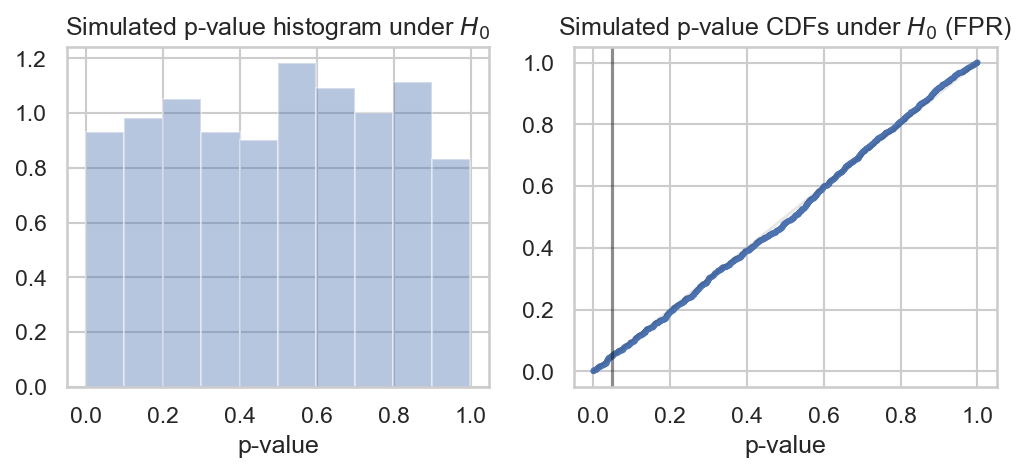

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(figsize[0] * 2, figsize[1]), dpi=dpi)

plot_cdf(p_vals.flatten(), "Delta-method", ax2)

ax2.plot(np.linspace(0, 1, 10000), np.linspace(0, 1, 10000), "k", alpha=0.1)
ax2.axvline(0.05, color="k", alpha=0.5)
ax2.set_title("Simulated p-value CDFs under $H_0$ (FPR)")
ax2.set_xlabel("p-value")

ax1.set_title("Simulated p-value histogram under $H_0$")
ax1.set_xlabel("p-value")
sns.distplot(p_vals.flatten(), ax=ax1, bins=10, kde=False, norm_hist=True)

plt.show()

Now let's check the same approach with a standard Binomial test.

In [53]:
def binomial_test(global_ratio_0, total_rides_0, global_ratio_1, total_rides_1):
    """
    Calculates two-sided p-values for the experiments on global cancels ratio using z-test
    :param global_ctr_0: np.array shape (n_experiments), global ctr in control group in every experiment
    :param total_rides_0: np.array shape (n_experiments), sum of views in control group in every experiment
    :param global_ctr_1: np.array shape (n_experiments), global ctr in treatment group in every experiment
    :param total_rides_1: np.array shape (n_experiments), sum of views in treatment group in every experiment
    :return: np.array shape (n_experiments), two-sided p-values of delta-method on CTRs in all the experimetns
    """
    overall_ctrs = (global_ratio_0 * total_rides_0 + global_ratio_1 * total_rides_1) / (
        total_rides_0 + total_rides_1
    )
    z_stats = (global_ratio_0 - global_ratio_1) / np.sqrt(
        overall_ctrs * (1 - overall_ctrs) * (1.0 / total_rides_0 + 1.0 / total_rides_1)
    )
    return 2 * np.minimum(
        scipy.stats.norm(0, 1).cdf(z_stats), 1 - scipy.stats.norm(0, 1).cdf(z_stats)
    )

In [54]:
global_ctr_0_aa = cancels_aa_0.sum(axis=1) / rides_aa_0.sum(axis=1)
global_ctr_1_aa = cancels_aa_1.sum(axis=1) / rides_aa_1.sum(axis=1)

p_vals = binomial_test(
    global_ctr_0_aa,
    rides_aa_0.sum(axis=1),
    global_ctr_1_aa,
    rides_aa_1.sum(axis=1),
)

print(f"Test power: {np.mean(p_vals > 0.05)}")

Test power: 0.88


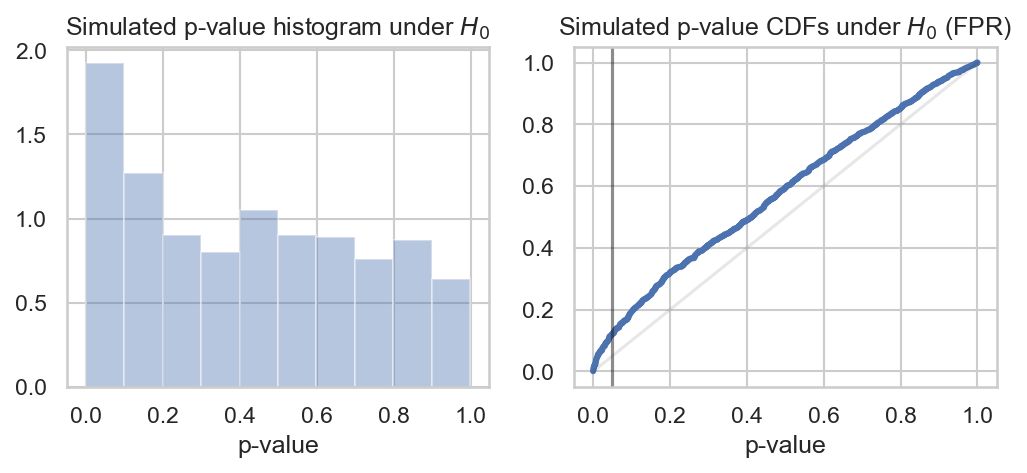

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(figsize[0] * 2, figsize[1]), dpi=dpi)

plot_cdf(p_vals.flatten(), "Delta-method", ax2)

ax2.plot(np.linspace(0, 1, 10000), np.linspace(0, 1, 10000), "k", alpha=0.1)
ax2.axvline(0.05, color="k", alpha=0.5)
ax2.set_title("Simulated p-value CDFs under $H_0$ (FPR)")
ax2.set_xlabel("p-value")

ax1.set_title("Simulated p-value histogram under $H_0$")
ax1.set_xlabel("p-value")
sns.distplot(p_vals.flatten(), ax=ax1, bins=10, kde=False, norm_hist=True)

plt.show()

### Logistic Regression

In [133]:
feature_cols = [
    "ride_type",
    "upfront_fare",
    "eta_to_rider_pre_match",
    "requested_at_local",
    "rider_request_number",
    "cancel_penalty",
    "cancellation_flag",
]

label_col = ["cancellation_flag"]

data = df.set_index("ride_id")[feature_cols]

#### Feature Engineering

In [134]:
data["day_of_week"] = data["requested_at_local"].dt.dayofweek

data["hour"] = data["requested_at_local"].dt.hour

bins = [-1, 5, 10, 15, 20, 23]

data["hour"] = pd.cut(
    data["hour"],
    bins=bins,
    labels=["late_night", "morning", "afternoon", "evening", "night"],
)

data.dropna(inplace=True)

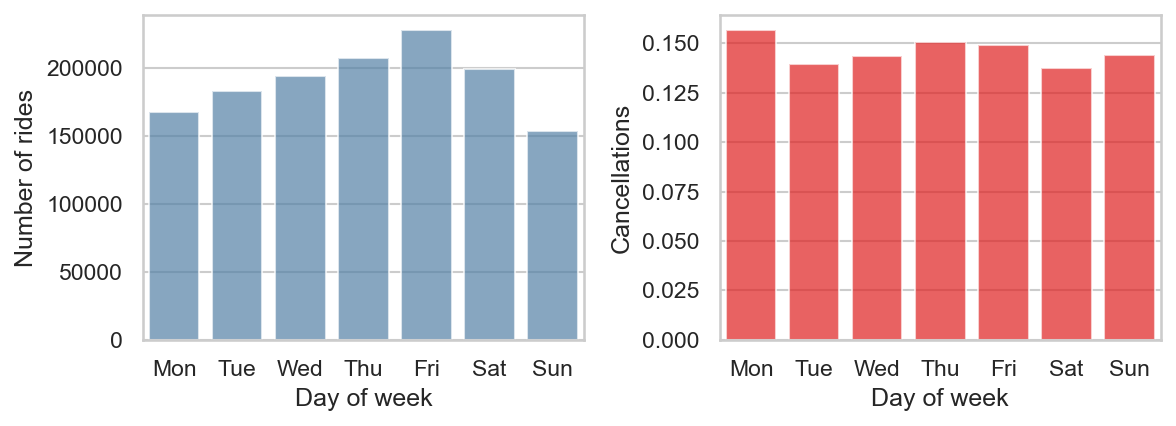

In [135]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(figsize[0] * 2, figsize[1]), dpi=dpi)

lbls = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

plot_data = (
    data[["day_of_week"]]
    .reset_index()
    .groupby("day_of_week")["ride_id"]
    .count()
    .reset_index()
)
sns.barplot(
    x="day_of_week", y="ride_id", data=plot_data, ax=ax1, color="steelblue", alpha=0.7
)
ax1.set_ylabel("Number of rides")
ax1.set_xticklabels(lbls)
ax1.set_xlabel("Day of week")

plot_data = (
    data[["cancellation_flag", "day_of_week"]]
    .groupby("day_of_week")["cancellation_flag"]
    .mean()
    .reset_index()
)
sns.barplot(
    x="day_of_week",
    y="cancellation_flag",
    data=plot_data,
    ax=ax2,
    color="red",
    alpha=0.7,
)
ax2.set_ylabel("Cancellations")
ax2.set_xticklabels(lbls)
ax2.set_xlabel("Day of week")

plt.tight_layout()
plt.show()

In [136]:
days = {0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}

data["day_of_week"] = data["day_of_week"].map(days)

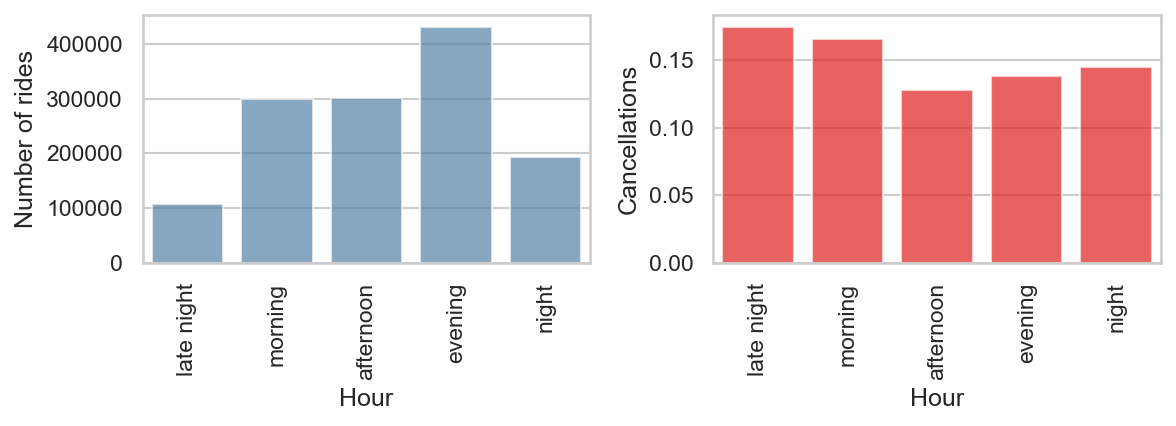

In [137]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(figsize[0] * 2, figsize[1]), dpi=dpi)

lbls = ["late night", "morning", "afternoon", "evening", "night"]

plot_data = (
    data[["hour"]].reset_index().groupby("hour")["ride_id"].count().reset_index()
)
sns.barplot(x="hour", y="ride_id", data=plot_data, ax=ax1, color="steelblue", alpha=0.7)
ax1.set_ylabel("Number of rides")
ax1.set_xlabel("Hour")
ax1.set_xticklabels(
    labels=lbls,
    rotation="vertical",
)

plot_data = (
    data[["cancellation_flag", "hour"]]
    .groupby("hour")["cancellation_flag"]
    .mean()
    .reset_index()
)
sns.barplot(
    x="hour", y="cancellation_flag", data=plot_data, ax=ax2, color="red", alpha=0.7
)
ax2.set_ylabel("Cancellations")
ax2.set_xlabel("Hour")
ax2.set_xticklabels(
    labels=lbls,
    rotation="vertical",
)

plt.tight_layout()
plt.show()

#### Discriminability by continuous features

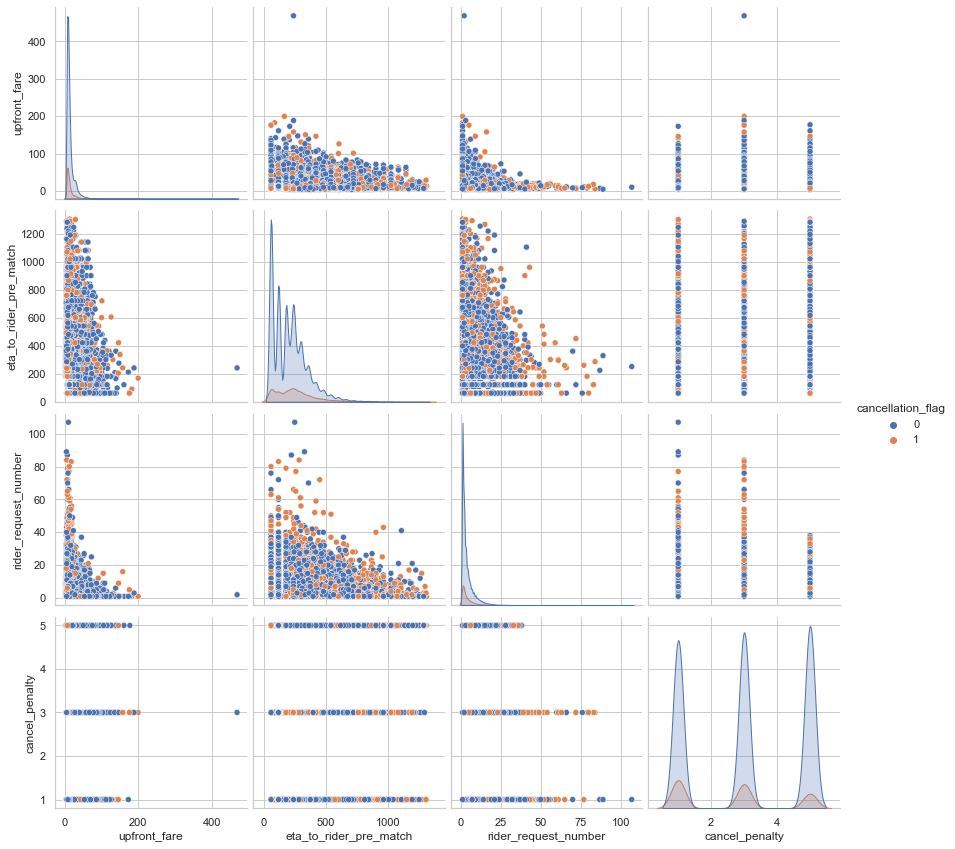

In [61]:
frac = 0.1

cols = [
    "upfront_fare",
    "eta_to_rider_pre_match",
    "cancellation_flag",
    "rider_request_number",
    "cancel_penalty",
]

sns.pairplot(data[cols].sample(frac=frac), hue="cancellation_flag", height=3.0)
plt.show()

#### Discriminability by categorical features

In [138]:
def compute_cramers_v(conf_matrix):
    chi2 = chi2_contingency(conf_matrix, correction=False)[0]
    n = conf_matrix.sum().sum()
    k1, k2 = conf_matrix.shape
    return np.sqrt(chi2 / (n * (min(k1, k2) - 1)))

In [139]:
for col_name in [
    "ride_type",
    "cancel_penalty",
    "day_of_week",
    "hour",
]:
    conf_matrix = pd.crosstab(data[col_name], data["cancellation_flag"])
    cramers_v = compute_cramers_v(conf_matrix)
    print("{} has Cramer's-V = {:.2}".format(col_name, cramers_v))
    print(conf_matrix)
    print("")
    print()

ride_type has Cramer's-V = 0.045
cancellation_flag       0       1
ride_type                        
shared             383747   77444
standard           753535  116884


cancel_penalty has Cramer's-V = 0.1
cancellation_flag       0      1
cancel_penalty                  
1.0                364103  83321
3.0                378600  67995
5.0                394579  43012


day_of_week has Cramer's-V = 0.017
cancellation_flag       0      1
day_of_week                     
Fri                193466  33951
Mon                141401  26240
Sat                171828  27384
Sun                131518  22175
Thu                175791  31243
Tue                157343  25527
Wed                165935  27808


hour has Cramer's-V = 0.044
cancellation_flag       0      1
hour                            
late_night          88321  18675
morning            248998  49430
afternoon          262237  38486
evening            371651  59641
night              166075  28096




Dummy-encoding before building a model (drop one value to avoid multicollinearity)

In [140]:
data = pd.get_dummies(data, columns=["ride_type", "day_of_week", "hour"])
data.drop(columns=["requested_at_local"], inplace=True)

In [142]:
data.drop(
    columns=["day_of_week_Sun", "ride_type_standard", "hour_afternoon"], inplace=True
)

Build one-factor models to evaluate the significance:

In [143]:
train_cols = set(data.columns) - {"cancellation_flag"}

one_dim_models_res = []
for feature_name in train_cols:
    model = smf.logit(f"cancellation_flag ~ {feature_name}", data).fit(disp=0)
    model.summary()
    one_dim_models_res.append(
        {
            "feature": feature_name,
            "AIC": model.aic,
            "LLR": model.llr,
            "LLR_pval": model.llr_pvalue,
        }
    )

one_dim_models_res = pd.DataFrame(one_dim_models_res).set_index("feature")

In [144]:
def get_significance(pval):
    if pval < 0.001:
        return "***"
    elif pval < 0.01:
        return "**"
    elif pval < 0.05:
        return "*"
    elif pval < 0.1:
        return "."
    else:
        return ""


one_dim_models_res.assign(
    significance=one_dim_models_res["LLR_pval"].apply(get_significance)
)

,AIC,LLR,LLR_pval,significance
feature,,,,
rider_request_number,1.104584e+06,2232.673851,0.000000e+00,***
day_of_week_Wed,1.106806e+06,10.555693,1.158308e-03,**
ride_type_shared,1.104128e+06,2689.303133,0.000000e+00,***
day_of_week_Fri,1.106792e+06,24.644831,6.892940e-07,***
hour_morning,1.105649e+06,1168.154373,5.085338e-256,***
upfront_fare,1.106808e+06,8.702938,3.176976e-03,**
eta_to_rider_pre_match,1.087633e+06,19183.910438,0.000000e+00,***
cancel_penalty,1.092995e+06,13821.967592,0.000000e+00,***
day_of_week_Thu,1.106769e+06,48.274955,3.704536e-12,***


In [145]:
train_cols -= {"hour_night"}

formula = f"cancellation_flag ~ {' + '.join(train_cols)}"
model = smf.logit(formula, data).fit(disp=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      cancellation_flag   No. Observations:              1331610
Model:                          Logit   Df Residuals:                  1331595
Method:                           MLE   Df Model:                           14
Date:                Tue, 16 Feb 2021   Pseudo R-squ.:                 0.03249
Time:                        15:55:33   Log-Likelihood:            -5.3542e+05
converged:                       True   LL-Null:                   -5.5341e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.9160      0.011   -178.789      0.000      -1.937      -1.895
rider_request_number       0.0225      0.001     40.674      0.000       0.021       0.024
day_of_week_Wed           -0.0013      0.010     -0.127      0.899      -0.021       0.018
ride_type_shared          -0.0887      0.006    -14.381      0.000      -0.101      -0.077
day_of_week_Fri            0.0554      0.010      5.812      0.000       0.037       0.074
hour_morning               0.1191      0.007     17.872      0.000       0.106       0.132
upfront_fare               0.0019      0.000      7.953      0.000       0.001       0.002
eta_to_rider_pre_match     0.0021    1.7e-05    126.131      0.000       0.002       0.002
cancel_penalty            -0.1807      0.002   -115.790      0.000      -0.184      -0.178
day_of_week_Thu            0.0522      0.010      5.377      0.000       0.033       0.071
hour_late_night            0.2099      0.009     22.513      0.000       0.192       0.228
day_of_week_Sat           -0.0167      0.010     -1.683      0.092      -0.036       0.003
day_of_week_Mon            0.0541      0.010      5.342      0.000       0.034       0.074
hour_evening               0.0308      0.006      4.996      0.000       0.019       0.043
day_of_week_Tue           -0.0278      0.010     -2.743      0.006      -0.048      -0.008
==========================================================================================
"""

In [146]:
def lr_test(m1, m2):
    statistics = np.abs(2 * (m1.llf - m2.llf))
    df = np.abs(m1.df_model - m2.df_model)
    pvalue = 1.0 - chi2.cdf(statistics, df=df)
    return statistics, pvalue

In [147]:
add_feature_results = []
delta_params = {}

features_used = model.model.exog_names
for feature_name in data.columns:
    if feature_name not in features_used + ["cancellation_flag"]:
        formula = model.model.formula + f" + {feature_name}"
        new_model = smf.logit(formula, data).fit(disp=0)
        add_feature_results.append(
            {
                "feature": feature_name,
                "AIC": new_model.aic,
                "LLR": new_model.llr,
                "LLR_pval": new_model.llr_pvalue,
                "lr_test_pval": lr_test(model, new_model)[1],
            }
        )
        cur_delta_params = (model.params - new_model.params) / model.params
        delta_params[feature_name] = cur_delta_params[features_used]

add_feature_results = pd.DataFrame(add_feature_results).set_index("feature")
delta_params = pd.DataFrame(delta_params).round(2)

In [148]:
add_feature_results

,AIC,LLR,LLR_pval,lr_test_pval
feature,,,,
hour_night,1.070615e+06,36230.125787,0.0,0.0


In [149]:
pd.DataFrame(delta_params).round(2)

,hour_night
Intercept,-0.03
rider_request_number,-0.01
day_of_week_Wed,-2.31
ride_type_shared,-0.02
day_of_week_Fri,0.10
hour_morning,-0.47
upfront_fare,0.05
eta_to_rider_pre_match,0.00
cancel_penalty,0.00
day_of_week_Thu,0.07


In [150]:
add_feature_results = []
features_used = model.model.exog_names

for i, feature_name_1 in tqdm(enumerate(features_used)):
    if feature_name_1 != "Intercept":
        for j, feature_name_2 in enumerate(features_used):
            if j > i and feature_name_2 != "Intercept":
                pair_of_new_features = f"{feature_name_1}:{feature_name_2}"
                if (
                    ("hour_" in pair_of_new_features)
                    or ("day_of_week" in pair_of_new_features)
                    or ("cancel_penalty" in pair_of_new_features)
                ):
                    continue
                formula = model.model.formula + f"+ {pair_of_new_features}"
                new_model = smf.logit(formula, data).fit(disp=0)
                add_feature_results.append(
                    {
                        "feature": pair_of_new_features,
                        "AIC": new_model.aic,
                        "LLR": new_model.llr,
                        "LLR_pval": new_model.llr_pvalue,
                        "lr_test_pval": lr_test(model, new_model)[1],
                    }
                )

add_feature_results = pd.DataFrame(add_feature_results).set_index("feature")

In [151]:
add_feature_results[add_feature_results["lr_test_pval"] < 0.05]

,AIC,LLR,LLR_pval,lr_test_pval
feature,,,,
rider_request_number:upfront_fare,1.070834e+06,36010.962601,0.0,1.109612e-11
rider_request_number:eta_to_rider_pre_match,1.070836e+06,36008.919491,0.0,3.149725e-11
ride_type_shared:eta_to_rider_pre_match,1.070459e+06,36385.438671,0.0,0.000000e+00
upfront_fare:eta_to_rider_pre_match,1.070740e+06,36104.887548,0.0,0.000000e+00


In [152]:
new_cols = add_feature_results[
    add_feature_results["lr_test_pval"] < 0.05
].index.tolist()
formula_cols = " + ".join(train_cols) + " + " + " + ".join(new_cols)

formula = f"cancellation_flag ~ {formula_cols}"
model2 = smf.logit(formula, data).fit(disp=0)
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      cancellation_flag   No. Observations:              1331610
Model:                          Logit   Df Residuals:                  1331591
Method:                           MLE   Df Model:                           18
Date:                Tue, 16 Feb 2021   Pseudo R-squ.:                 0.03328
Time:                        15:57:07   Log-Likelihood:            -5.3499e+05
converged:                       True   LL-Null:                   -5.5341e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -2.0193      0.013   -155.228      0.000      -2.045      -1.994
rider_request_number                            0.0100      0.001      7.380      0.000       0.007       0.013
day_of_week_Wed                                -0.0066      0.010     -0.660      0.509      -0.026       0.013
ride_type_shared                                0.1583      0.012     13.452      0.000       0.135       0.181
day_of_week_Fri                                 0.0507      0.010      5.314      0.000       0.032       0.069
hour_morning                                    0.1144      0.007     17.141      0.000       0.101       0.128
upfront_fare                                    0.0062      0.000     14.121      0.000       0.005       0.007
eta_to_rider_pre_match                          0.0028   3.61e-05     76.568      0.000       0.003       0.003
cancel_penalty                                 -0.1808      0.002   -115.815      0.000      -0.184      -0.178
day_of_week_Thu                                 0.0472      0.010      4.852      0.000       0.028       0.066
hour_late_night                                 0.2079      0.009     22.289      0.000       0.190       0.226
day_of_week_Sat                                -0.0196      0.010     -1.978      0.048      -0.039      -0.000
day_of_week_Mon                                 0.0493      0.010      4.862      0.000       0.029       0.069
hour_evening                                    0.0296      0.006      4.804      0.000       0.018       0.042
day_of_week_Tue                                -0.0326      0.010     -3.215      0.001      -0.052      -0.013
rider_request_number:upfront_fare               0.0005   6.41e-05      7.788      0.000       0.000       0.001
rider_request_number:eta_to_rider_pre_match  2.571e-05   3.46e-06      7.440      0.000    1.89e-05    3.25e-05
ride_type_shared:eta_to_rider_pre_match        -0.0009   3.61e-05    -25.524      0.000      -0.001      -0.001
upfront_fare:eta_to_rider_pre_match         -2.365e-05   1.36e-06    -17.404      0.000   -2.63e-05    -2.1e-05
===============================================================================================================
"""

In [153]:
print(model2.aic) 
print(model.aic)
print(lr_test(model2, model))

1070013.1864889746
1070878.0195923846
(872.8331034099683, 0.0)


The results are significantly better!

Remove features with p-value above 0.05

In [154]:
formula_cols = " + ".join(
    set(model2.pvalues[model2.pvalues < 0.05].index.tolist()) - {"Intercept"}
)

formula = f"cancellation_flag ~ {formula_cols}"

model3 = smf.logit(formula, data).fit(disp=0)
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      cancellation_flag   No. Observations:              1331610
Model:                          Logit   Df Residuals:                  1331592
Method:                           MLE   Df Model:                           17
Date:                Tue, 16 Feb 2021   Pseudo R-squ.:                 0.03328
Time:                        15:57:23   Log-Likelihood:            -5.3499e+05
converged:                       True   LL-Null:                   -5.5341e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -2.0228      0.012   -170.469      0.000      -2.046      -2.000
rider_request_number                            0.0100      0.001      7.380      0.000       0.007       0.013
ride_type_shared                                0.1582      0.012     13.446      0.000       0.135       0.181
hour_morning                                    0.1142      0.007     17.133      0.000       0.101       0.127
day_of_week_Fri                                 0.0544      0.008      7.026      0.000       0.039       0.070
rider_request_number:upfront_fare               0.0005   6.41e-05      7.787      0.000       0.000       0.001
upfront_fare                                    0.0062      0.000     14.114      0.000       0.005       0.007
upfront_fare:eta_to_rider_pre_match         -2.362e-05   1.36e-06    -17.393      0.000   -2.63e-05    -2.1e-05
eta_to_rider_pre_match                          0.0028   3.61e-05     76.569      0.000       0.003       0.003
day_of_week_Tue                                -0.0289      0.008     -3.421      0.001      -0.045      -0.012
cancel_penalty                                 -0.1808      0.002   -115.815      0.000      -0.184      -0.178
day_of_week_Thu                                 0.0509      0.008      6.402      0.000       0.035       0.066
hour_late_night                                 0.2084      0.009     22.395      0.000       0.190       0.227
ride_type_shared:eta_to_rider_pre_match        -0.0009   3.61e-05    -25.521      0.000      -0.001      -0.001
day_of_week_Sat                                -0.0160      0.008     -1.936      0.053      -0.032       0.000
day_of_week_Mon                                 0.0530      0.008      6.268      0.000       0.036       0.070
hour_evening                                    0.0294      0.006      4.781      0.000       0.017       0.041
rider_request_number:eta_to_rider_pre_match   2.57e-05   3.46e-06      7.438      0.000    1.89e-05    3.25e-05
===============================================================================================================
"""

In [155]:
print(model3.aic)
print(model2.aic)
print(lr_test(model3, model2))

1070011.621965642
1070013.1864889746
(0.43547666748054326, 0.5093137944382974)


Model quality hasn't got worse.

Now let's get rid of some influential observations

In [156]:
final_formula = model3.model.formula

cooks_model = smf.glm(
    formula=final_formula, data=data, family=sm.families.Binomial()
).fit(disp=0)

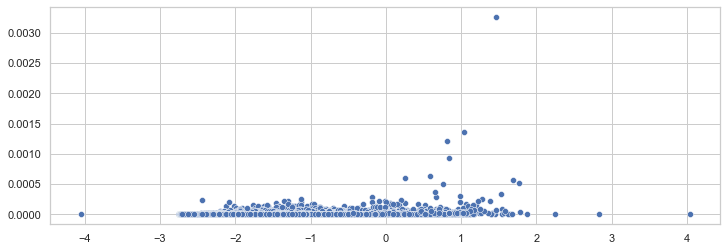

In [157]:
infl = cooks_model.get_influence()
plt.figure(figsize=(12, 4))
sns.scatterplot(model3.fittedvalues, infl.cooks_distance[0])
plt.show()

In [158]:
new_data = data[infl.cooks_distance[0] < 0.0005]
print("Fitting on {} / {} of samples".format(len(new_data), len(data)))
model_cooks = smf.logit(final_formula, data=new_data).fit()
model_cooks.summary()

Fitting on 1331602 / 1331610 of samples
Optimization terminated successfully.
         Current function value: 0.401754
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      cancellation_flag   No. Observations:              1331602
Model:                          Logit   Df Residuals:                  1331584
Method:                           MLE   Df Model:                           17
Date:                Tue, 16 Feb 2021   Pseudo R-squ.:                 0.03330
Time:                        15:58:03   Log-Likelihood:            -5.3498e+05
converged:                       True   LL-Null:                   -5.5341e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -2.0212      0.012   -170.229      0.000      -2.044      -1.998
rider_request_number                            0.0091      0.001      6.694      0.000       0.006       0.012
ride_type_shared                                0.1590      0.012     13.511      0.000       0.136       0.182
hour_morning                                    0.1141      0.007     17.130      0.000       0.101       0.127
day_of_week_Fri                                 0.0543      0.008      7.019      0.000       0.039       0.069
rider_request_number:upfront_fare               0.0006   6.57e-05      8.492      0.000       0.000       0.001
upfront_fare                                    0.0061      0.000     13.853      0.000       0.005       0.007
upfront_fare:eta_to_rider_pre_match         -2.367e-05   1.36e-06    -17.419      0.000   -2.63e-05    -2.1e-05
eta_to_rider_pre_match                          0.0028   3.61e-05     76.478      0.000       0.003       0.003
day_of_week_Tue                                -0.0289      0.008     -3.429      0.001      -0.045      -0.012
cancel_penalty                                 -0.1808      0.002   -115.816      0.000      -0.184      -0.178
day_of_week_Thu                                 0.0508      0.008      6.398      0.000       0.035       0.066
hour_late_night                                 0.2083      0.009     22.389      0.000       0.190       0.227
ride_type_shared:eta_to_rider_pre_match        -0.0009   3.61e-05    -25.549      0.000      -0.001      -0.001
day_of_week_Sat                                -0.0160      0.008     -1.942      0.052      -0.032       0.000
day_of_week_Mon                                 0.0529      0.008      6.265      0.000       0.036       0.069
hour_evening                                    0.0295      0.006      4.789      0.000       0.017       0.042
rider_request_number:eta_to_rider_pre_match  2.651e-05   3.46e-06      7.656      0.000    1.97e-05    3.33e-05
===============================================================================================================
"""

In [159]:
final_model = model_cooks

In [160]:
scores = 1.0 / (1.0 + np.exp(-final_model.fittedvalues))

idx = np.random.choice(len(scores), 5000)
scores = scores.iloc[idx]
sorted_scores = np.sort(scores)

labels = new_data["cancellation_flag"].iloc[idx]
n1 = labels.sum()
n = len(labels)

sensitivity = np.zeros_like(scores)
specificity = np.zeros_like(scores)

for j, u in tqdm(enumerate(sorted_scores)):
    sensitivity[j] = np.sum((scores >= u) * labels) / float(n1)
    specificity[j] = np.sum((scores <= u) * (1 - labels)) / float(n - n1)

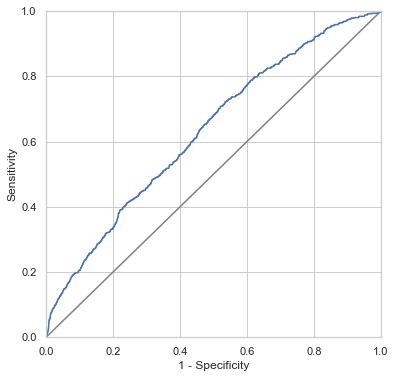

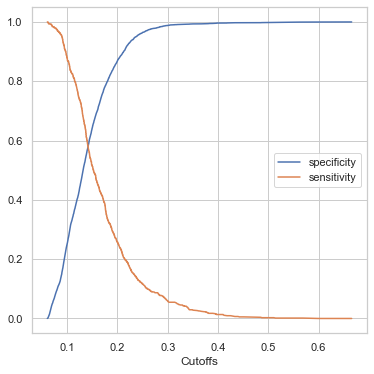

In [161]:
plt.figure(figsize=(6, 6))
sns.lineplot(1 - specificity, sensitivity)
plt.plot([0, 1], [0, 1], "-", color="grey")
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.figure(figsize=(6, 6))
sns.lineplot(sorted(scores), specificity, label="specificity")
sns.lineplot(sorted(scores), sensitivity, label="sensitivity")
plt.xlabel("Cutoffs")
plt.show()

In [162]:
idx = np.nonzero(sorted_scores >= 0.15)[0][0]
print(
    "For cutoff {:.4f}: specificity={:.4f}, sensitivity={:.5f}".format(
        scores[idx], specificity[idx], sensitivity[idx]
    )
)

For cutoff 0.0657: specificity=0.6427, sensitivity=0.51535


In [163]:
confint_results = np.exp(
    pd.concat((final_model.params, final_model.conf_int()), axis=1)
)
confint_results.columns = ["coef", "confint_2.5", "confint_97.5"]
confint_results["abs_coef"] = confint_results["coef"].apply(
    lambda x: x if x > 1 else 1 / x
)
confint_results.sort_values(by="abs_coef", ascending=False).round(3)

,coef,confint_2.5,confint_97.5,abs_coef
Intercept,0.132,0.129,0.136,7.547
hour_late_night,1.232,1.209,1.254,1.232
cancel_penalty,0.835,0.832,0.837,1.198
ride_type_shared,1.172,1.146,1.200,1.172
hour_morning,1.121,1.106,1.136,1.121
day_of_week_Fri,1.056,1.040,1.072,1.056
day_of_week_Mon,1.054,1.037,1.072,1.054
day_of_week_Thu,1.052,1.036,1.069,1.052
hour_evening,1.030,1.018,1.042,1.030
day_of_week_Tue,0.971,0.956,0.988,1.029


In [164]:
list(data)

['upfront_fare',
 'eta_to_rider_pre_match',
 'rider_request_number',
 'cancel_penalty',
 'cancellation_flag',
 'ride_type_shared',
 'day_of_week_Fri',
 'day_of_week_Mon',
 'day_of_week_Sat',
 'day_of_week_Thu',
 'day_of_week_Tue',
 'day_of_week_Wed',
 'hour_late_night',
 'hour_morning',
 'hour_evening',
 'hour_night']